<a href="https://colab.research.google.com/github/hubertmaka/gesture-recognition/blob/main/gesture_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition Notebook

## 1. Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Unpack dataset on Google Drive

In [ ]:
import zipfile
import os
from tqdm import tqdm

def unzip_file_with_progress(zip_file_path, output_dir):
    if not os.path.exists(zip_file_path):
        print(f"File {zip_file_path} does not exist.")
        return

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_list = zip_ref.infolist()
        total_files = len(file_list)

        with tqdm(total=total_files, unit='file') as pbar:
            for file_info in file_list:
                zip_ref.extract(file_info, output_dir)
                pbar.update(1)

        print(f"File {zip_file_path} unarchived to {output_dir}")

def unzip_all_files_in_folder():
  for i in range(1, 18):
    zip_file_path = f'/content/drive/MyDrive/gesture-recognition/kat{i}.zip'
    output_dir = f'/content/drive/MyDrive/gesture-recognition/data/kat{i}'
    unzip_file_with_progress(zip_file_path, output_dir)


## 3. Import libraries

In [2]:
import os
import datetime
import logging
from dataclasses import dataclass
import sys

from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import matplotlib as matplb

In [3]:
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Matplotlib Version: {matplb.__version__}")
print(f"Python Version: {sys.version}")

TensorFlow Version: 2.17.0
Keras Version: 3.4.1
Pandas Version: 2.2.2
Numpy Version: 1.26.4
Matplotlib Version: 3.7.1
Python Version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [4]:
JESTER_DATASET_DIR_PATH = os.path.join("/", "content", "drive", "MyDrive", "gesture-recognition")
TRAIN_INFO_PATH = os.path.join(JESTER_DATASET_DIR_PATH, "info", "jester-v1-train.csv")
VAL_INFO_PATH = os.path.join(JESTER_DATASET_DIR_PATH, "info", "jester-v1-validation.csv")
TEST_INFO_PATH = os.path.join(JESTER_DATASET_DIR_PATH, "info", "jester-v1-test.csv")
LABELS_INFO_PATH = os.path.join(JESTER_DATASET_DIR_PATH, "info", 'jester-v1-labels.csv')
VIDEO_DIR_PATH = os.path.join(JESTER_DATASET_DIR_PATH, "data")

## 4. Dataset analysis

### 4.1 Config:

In [ ]:
pd.options.mode.copy_on_write = True
DIR_SPLIT_BATCH_SIZE = 9000

### 4.2 Data preprocessing:

In [ ]:
column_names = ["video_id", "label"]
train_df = pd.read_csv(TRAIN_INFO_PATH, names=column_names, header=None, delimiter=";")
val_df = pd.read_csv(VAL_INFO_PATH, names=column_names, header=None, delimiter=";")
test_df = pd.read_csv(TEST_INFO_PATH, names=column_names, header=None, delimiter=";")

In [ ]:
train_df

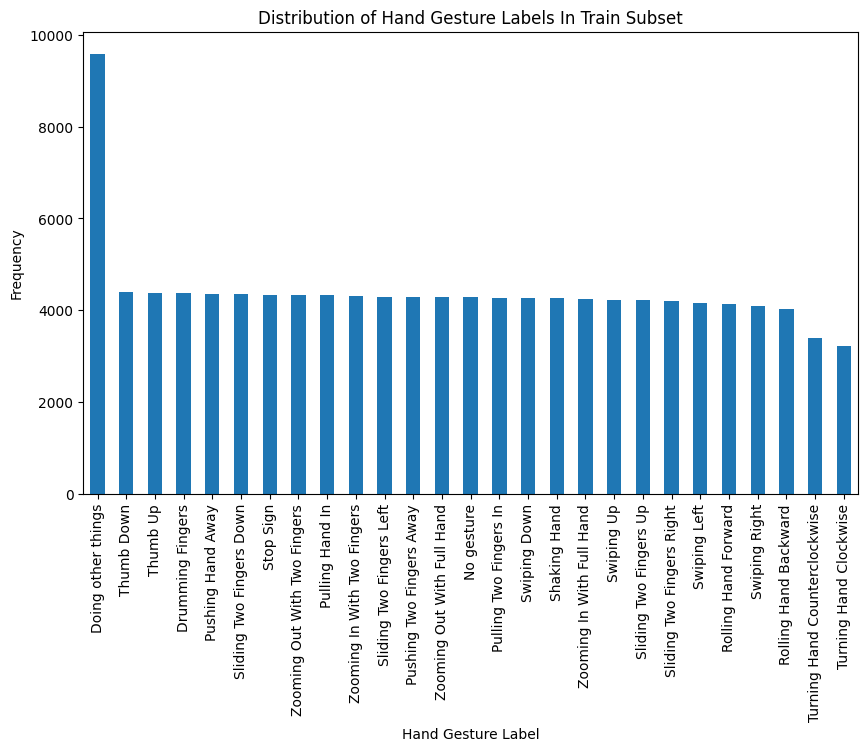

In [ ]:
# @title Distribution of Hand Gesture Labels In Train Subset

plt.figure(figsize=(10, 6))
train_df['label'].value_counts().plot(kind='bar')
plt.xlabel('Hand Gesture Label')
plt.ylabel('Frequency')
_ = plt.title('Distribution of Hand Gesture Labels In Train Subset')

In [ ]:
val_df

In [ ]:
# @title Distribution of Hand Gesture Labels In Val Subset

plt.figure(figsize=(10, 6))
val_df['label'].value_counts().plot(kind='bar')
plt.xlabel('Hand Gesture Label')
plt.ylabel('Frequency')
_ = plt.title('Distribution of Hand Gesture Labels In Val Subset')

In [ ]:
test_df

In [ ]:
print(f"Number of all videos: {len(train_df) + len(val_df) + len(test_df)}")

#### Loading labels:

In [ ]:
jester_labels = {}
with open(LABELS_INFO_PATH) as f:
    for idx2, line in enumerate(f):
        jester_labels[line.strip()] = idx2

In [ ]:
jester_labels

#### Adding label id to DataFrame:

In [ ]:
train_df["label_id"] = train_df["label"].apply(lambda label: jester_labels.get(label))
val_df["label_id"] = train_df["label"].apply(lambda label: jester_labels.get(label))

In [ ]:
train_df

In [ ]:
val_df

#### Adding Video Path To DataFrame:

In [ ]:
def get_directory_path(catalog_id, main_directory, batch_size):
  batch_num = (catalog_id - 1) // batch_size + 1
  batch_dir = f"kat{batch_num}"
  directory_path = os.path.join(main_directory, batch_dir, str(catalog_id))
  return directory_path

In [ ]:
train_df["path"] = train_df["video_id"].apply(lambda video_id: get_directory_path(main_directory=VIDEO_DIR_PATH, catalog_id=video_id, batch_size=DIR_SPLIT_BATCH_SIZE))
val_df["path"] = val_df["video_id"].apply(lambda video_id: get_directory_path(main_directory=VIDEO_DIR_PATH, catalog_id=video_id, batch_size=DIR_SPLIT_BATCH_SIZE))

In [ ]:
train_df

In [ ]:
val_df

#### Mapping Labels To DataFrame:

In [ ]:
mapped_labels = train_df[["label", "label_id"]].drop_duplicates().sort_values(by=["label_id"])

In [ ]:
mapped_labels

#### Getting Sequence Length:

In [ ]:
def get_sequence_len(path: str) -> int:
  return len([file for file in os.listdir(path) if file.endswith(".jpg")])

In [ ]:
train_df["seq_len"] = train_df["path"].apply(lambda path: get_sequence_len(path))
val_df["seq_len"] = val_df["path"].apply(lambda path: get_sequence_len(path))

In [ ]:
train_df

In [ ]:
val_df

#### Saving DataFrames to csv files:

In [ ]:
train_df.to_csv(os.path.join(JESTER_DATASET_DIR_PATH, "info", "train_df.csv"), index=False)

In [ ]:
val_df.to_csv(os.path.join(JESTER_DATASET_DIR_PATH, "info", "val_df.csv"), index=False)

## 5. Prepare Data Info To Pipeline

### 5.1 Config:

In [5]:
train_df = pd.read_csv(os.path.join(JESTER_DATASET_DIR_PATH, "info", "train_df.csv"))
val_df = pd.read_csv(os.path.join(JESTER_DATASET_DIR_PATH, "info", "val_df.csv"))

In [6]:
labels_info = pd.read_csv(os.path.join(JESTER_DATASET_DIR_PATH, "info", "jester-v1-labels.csv"))
labels_info

,Swiping Left
0,Swiping Right
1,Swiping Down
2,Swiping Up
3,Pushing Hand Away
4,Pulling Hand In
5,Sliding Two Fingers Left
6,Sliding Two Fingers Right
7,Sliding Two Fingers Down
8,Sliding Two Fingers Up
9,Pushing Two Fingers Away


In [48]:
SET_SIZE = 5_000
TRAIN_SET_SIZE = 0.7 * SET_SIZE
VAL_SET_SIZE = SET_SIZE - TRAIN_SET_SIZE
MIN_SEQ_LEN = 30
CLASSES = [1, 25, 19]
CLASSES_PERCENTAGE = [1/len(CLASSES) for _ in range(len(CLASSES))]
CLASSES_WITH_PERCENTAGE = {cls: percentage for cls, percentage in zip(CLASSES, CLASSES_PERCENTAGE)}
TRAIN_CLASSES_WITH_AMOUNT = {cls: int(percentage * TRAIN_SET_SIZE) for cls, percentage in zip(CLASSES, CLASSES_PERCENTAGE)}
VAL_CLASSES_WITH_AMOUNT = {cls: int(percentage * VAL_SET_SIZE) for cls, percentage in zip(CLASSES, CLASSES_PERCENTAGE)}
CLASS_MAPPING = {cls: idx for idx, cls in enumerate(CLASSES)}

In [49]:
CLASSES_WITH_PERCENTAGE

{1: 0.3333333333333333, 25: 0.3333333333333333, 19: 0.3333333333333333}

In [50]:
TRAIN_CLASSES_WITH_AMOUNT

{1: 1166, 25: 1166, 19: 1166}

In [51]:
VAL_CLASSES_WITH_AMOUNT

{1: 500, 25: 500, 19: 500}

In [52]:
CLASS_MAPPING

{1: 0, 25: 1, 19: 2}

### 5.2 Create subsets:

In [53]:
def preprocess_df(dataframe: pd.DataFrame, subset_info: dict[int, int], min_seq_len: int) -> pd.DataFrame:
    def _get_longer_seq_len_than(df: pd.DataFrame, seq_len: int) -> pd.DataFrame:
        return df[df["seq_len"] >= seq_len]

    def _get_df_subset(df: pd.DataFrame, classes_with_amount: dict[int, int]) -> pd.DataFrame:
        missing_probes = 0
        subset_df = pd.DataFrame()
        for key, val in classes_with_amount.items():
            try:
                missing_probes = 0 if (val - len(df[df["label_id"] == key])) < 0 else (val - len(df[df["label_id"] == key]))
                subset_df = pd.concat([subset_df, df[df["label_id"] == key].sample(n=val)])
            except ValueError:
                logging.warning(f"Needed to duplicate {missing_probes}. DO NOT LEARN NETWORK WITHOUT AUGMENTATION")
                subset_df = pd.concat([subset_df, df[df["label_id"] == key].sample(n=val, replace=True)])
        return subset_df.sample(frac=1, ignore_index=True)

    # new_df = _get_longer_seq_len_than(dataframe, min_seq_len)
    new_df = _get_df_subset(dataframe, subset_info)
    return new_df

In [54]:
train_subset_df = preprocess_df(train_df, TRAIN_CLASSES_WITH_AMOUNT, MIN_SEQ_LEN)
val_subset_df = preprocess_df(val_df, VAL_CLASSES_WITH_AMOUNT, MIN_SEQ_LEN)

## 6. Create `tf.data.Dataset` Pipeline:

In [23]:
logging.basicConfig(
    format="{asctime} - {levelname} - {message}",
    style="{",
    datefmt="%Y-%m-%d %H:%M",
    level=logging.INFO
)


def create_dataset_from_dir(df: pd.DataFrame, seq_len: int):
    sequences = []
    labels = []

    for _, row in df.iterrows():
        video_path = row['path']
        label_id = row['label_id']
        image_paths = generate_image_paths(video_path, seq_len, row)
        sequences.append(image_paths)
        labels.append(label_id)

    dataset = tf.data.Dataset.from_tensor_slices((sequences, labels))
    return dataset


@dataclass
class InputShape:
    weight: int
    height: int
    channels: int

    def as_tuple(self) -> tuple[int, int, int]:
        return self.weight, self.height, self.channels


def build_feature_extractor(inp_shape: InputShape):
    extractor_model = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=inp_shape.as_tuple()
    )

    preprocess_input = keras.applications.inception_v3.preprocess_input  # getting preprocess func
    inputs = keras.Input(inp_shape.as_tuple())
    preprocessed = preprocess_input(inputs)
    outputs = extractor_model(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor(InputShape(224, 224, 3))


@tf.function
def extract_features(images: tf.Tensor, label: int):
    features = tf.map_fn(lambda img: feature_extractor(img[np.newaxis, ...]), images, fn_output_signature=tf.float32)
    return features, label


def generate_image_paths(video_dir_path: str, seq_len: int, row: pd.Series):
    image_paths = []
    current_frames: int = row["seq_len"]

    if current_frames >= seq_len:
        mid_point = current_frames // 2
        start_point = max(0, mid_point - seq_len // 2)
        end_point = start_point + seq_len

        for i in range(start_point + 1, end_point + 1):
            img_name = f"{i:05d}.jpg"
            img_path = os.path.join(video_dir_path, img_name)
            image_paths.append(img_path)

    else:
        logging.warning(f"ADD PADDING ON LEFT AND RIGHT SIDE ON {row['video_id']}")
        padding_needed = seq_len - current_frames
        left_padding = padding_needed // 2
        right_padding = padding_needed - left_padding

        most_left_img = f"00001.jpg"
        most_right_img = f"{current_frames:05d}.jpg"

        for i in range(left_padding):
            img_path = os.path.join(video_dir_path, most_left_img)
            image_paths.append(img_path)

        for i in range(1, current_frames + 1):
            img_name = f"{i:05d}.jpg"
            img_path = os.path.join(video_dir_path, img_name)
            image_paths.append(img_path)

        for i in range(right_padding):
            img_path = os.path.join(video_dir_path, most_right_img)
            image_paths.append(img_path)

    if len(image_paths) != seq_len:
        raise ValueError(f"Missing images in dir: {video_dir_path}")

    return image_paths


@tf.function
def load_sequence_from_dir(image_paths: tf.Tensor, label: int, inp_shape: tuple[int, int, int]):
    def process_image(img_path):
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image, channels=inp_shape[2])
        image = tf.image.resize(image, inp_shape[:2])
        return image

    images = tf.map_fn(process_image, image_paths, fn_output_signature=tf.float32)

    return images, label


@tf.function
def one_hot_encode(path: tf.Tensor, label: int, classes_num: int, class_mapping: dict[int, int]):
    mapped_label = class_mapping[label]
    return path, tf.one_hot(mapped_label, classes_num, dtype=tf.int32)


@tf.function
def remove_one_dimensions(images: tf.Tensor, label: int):
    return tf.squeeze(images), label


def create_pipeline(df: pd.DataFrame, *, num_classes: int, image_input_shape: InputShape, seq_len: int, batch_size: int) -> tf.data.Dataset:
  ds = create_dataset_from_dir(df, seq_len=seq_len) # (list with paths strs)
  ds = ds.map(lambda images, label: one_hot_encode(images, label, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.map(lambda path, label: load_sequence_from_dir(path, label, image_input_shape.as_tuple()), num_parallel_calls=tf.data.AUTOTUNE) # (seq_len, width, height, channels)
  ds = ds.map(lambda images, label: extract_features(images, label), num_parallel_calls=tf.data.AUTOTUNE)  # (seq_len, 1, 2048)
  ds = ds.map(lambda images, label: remove_one_dimensions(images, label), num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.batch(batch_size=batch_size, drop_remainder=True)
  ds = ds.cache().prefetch(tf.data.AUTOTUNE)
  return ds

### 6.1 Config:

In [24]:
class PipelineConfig:
  IMAGE_INPUT_SHAPE = InputShape(224, 224, 3)
  NUM_CLASSES = len(CLASSES)
  BATCH_SIZE = 32
  SEQ_LEN = 30

#### 6.2 Pipeline:

In [25]:
train_ds = create_pipeline(
    train_subset_df,
    num_classes=PipelineConfig.NUM_CLASSES,
    image_input_shape=PipelineConfig.IMAGE_INPUT_SHAPE,
    seq_len=PipelineConfig.SEQ_LEN,
    batch_size=PipelineConfig.BATCH_SIZE
)

val_ds = create_pipeline(
    val_subset_df,
    num_classes=PipelineConfig.NUM_CLASSES,
    image_input_shape=PipelineConfig.IMAGE_INPUT_SHAPE,
    seq_len=PipelineConfig.SEQ_LEN,
    batch_size=PipelineConfig.BATCH_SIZE
)

In [26]:
MODEL_INPUT_SHAPE = train_ds.as_numpy_iterator().next()[0].shape[1:]
MODEL_INPUT_SHAPE

KeyboardInterrupt: 

## 7. Create Model

### 7.1 Config:

In [27]:
MODEL_INPUT_SHAPE

(30, 2048)

In [28]:
def build_lstm_model(input_shape: tuple[int, int], num_classes: int):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(input_shape))
    model.add(keras.layers.LSTM(units=16, return_sequences=False))
    model.add(keras.layers.Dense(units=8, activation="relu"))
    model.add(keras.layers.Dense(units=num_classes, activation="softmax"))
    return model

In [29]:
lstm_model = build_lstm_model(input_shape=MODEL_INPUT_SHAPE, num_classes=len(CLASSES))

lstm_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 16)                  │         132,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,323 (516.89 KB)

 Trainable params: 132,323 (516.89 KB)

 Non-trainable params: 0 (0.00 B)

## 8. Train Model

### 8.1 Config:

In [30]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience = 10,
    monitor = 'val_loss',
    mode="min"
)

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'model_1.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

history = lstm_model.fit(train_ds, epochs=50, validation_data=val_ds, batch_size=PipelineConfig.BATCH_SIZE, callbacks=[early_stopping_callback, checkpoint_callback])

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1278s 63s/step - accuracy: 0.2125 - loss: 0.3581 - val_accuracy: 0.0000e+00 - val_loss: 0.4270
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.4346 - val_accuracy: 0.0000e+00 - val_loss: 0.3580
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.3759 - val_accuracy: 0.0000e+00 - val_loss: 0.3550
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.3616 - val_accuracy: 0.0000e+00 - val_loss: 0.3410
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.3501 - val_accuracy: 0.0000e+00 - val_loss: 0.3286
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.3380 - val_accuracy: 0.0000e+00 - val_loss: 0.3151
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0036 - loss: 0.3186 - val_accuracy: 0.0000e+00 - val_loss: 0.2990
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.000

Plots saved as 'training_plots_1000.png'


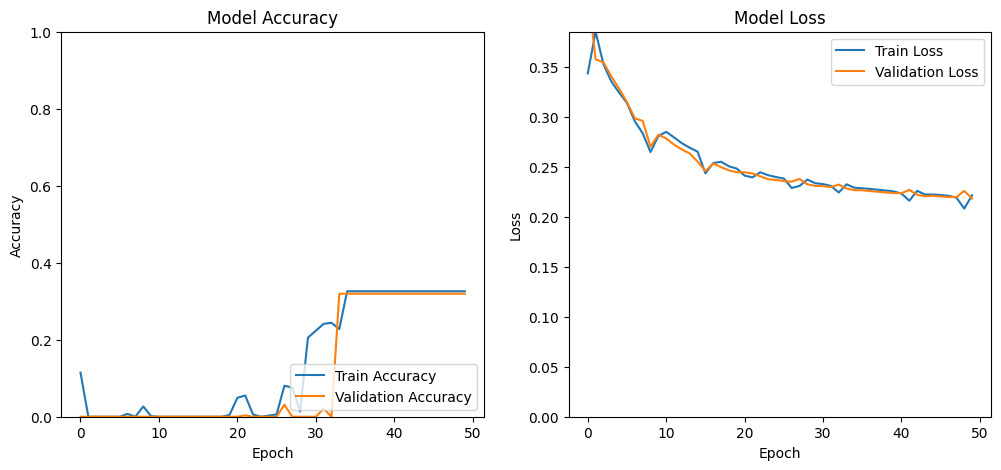

In [31]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(history.history['loss'])])
plt.legend(loc='upper right')
plt.title('Model Loss')


plt.savefig('/content/drive/MyDrive/training_plots_1000.png')

print("Plots saved as 'training_plots_1000.png'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

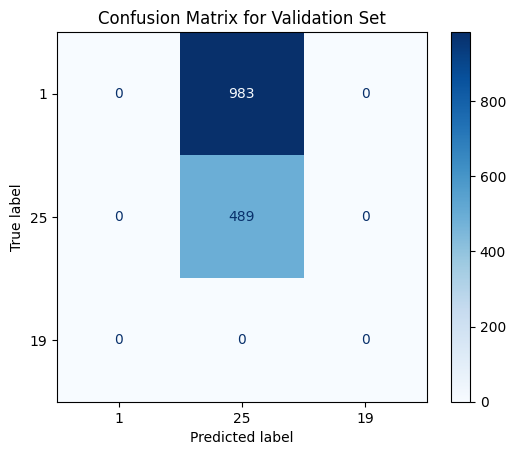

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Get predictions and true labels
y_pred = []
y_true = []

# Iterate over the validation dataset to get predictions and true labels
for images, labels in val_ds:
    # Predict classes for the current batch
    predictions = lstm_model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    y_pred.extend(predicted_classes)
    y_true.extend(true_classes)

# Step 2: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(CLASSES)))

# Step 3 (optional): Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Validation Set")
plt.show()

In [32]:
SET_SIZE = 5_000
TRAIN_SET_SIZE = 0.7 * SET_SIZE
VAL_SET_SIZE = SET_SIZE - TRAIN_SET_SIZE
MIN_SEQ_LEN = 34
CLASSES = [1, 25, 19]
CLASSES_PERCENTAGE = [1/len(CLASSES) for _ in range(len(CLASSES))]
CLASSES_WITH_PERCENTAGE = {cls: percentage for cls, percentage in zip(CLASSES, CLASSES_PERCENTAGE)}
TRAIN_CLASSES_WITH_AMOUNT = {cls: int(percentage * TRAIN_SET_SIZE) for cls, percentage in zip(CLASSES, CLASSES_PERCENTAGE)}
VAL_CLASSES_WITH_AMOUNT = {cls: int(percentage * VAL_SET_SIZE) for cls, percentage in zip(CLASSES, CLASSES_PERCENTAGE)}


train_subset_df = preprocess_df(train_df, TRAIN_CLASSES_WITH_AMOUNT, MIN_SEQ_LEN)
val_subset_df = preprocess_df(val_df, VAL_CLASSES_WITH_AMOUNT, MIN_SEQ_LEN)


train_ds = create_pipeline(
    train_subset_df,
    num_classes=PipelineConfig.NUM_CLASSES,
    image_input_shape=PipelineConfig.IMAGE_INPUT_SHAPE,
    seq_len=PipelineConfig.SEQ_LEN,
    batch_size=PipelineConfig.BATCH_SIZE
)

val_ds = create_pipeline(
    val_subset_df,
    num_classes=PipelineConfig.NUM_CLASSES,
    image_input_shape=PipelineConfig.IMAGE_INPUT_SHAPE,
    seq_len=PipelineConfig.SEQ_LEN,
    batch_size=PipelineConfig.BATCH_SIZE
)

def build_lstm_model(input_shape: tuple[int, int], num_classes: int):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(input_shape))
    model.add(keras.layers.LSTM(units=32, return_sequences=True))
    model.add(keras.layers.LSTM(units=16, return_sequences=False))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(units=8, activation="relu"))
    model.add(keras.layers.Dense(units=num_classes, activation="softmax"))
    return model

lstm_model = build_lstm_model(input_shape=MODEL_INPUT_SHAPE, num_classes=len(CLASSES))

lstm_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience = 10,
    monitor = 'val_loss',
    mode="min"
)

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'model_2.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

history = lstm_model.fit(train_ds, epochs=50, validation_data=val_ds, batch_size=PipelineConfig.BATCH_SIZE, callbacks=[early_stopping_callback, checkpoint_callback])


Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 6191s 57s/step - accuracy: 0.2614 - loss: 0.3300 - val_accuracy: 0.0000e+00 - val_loss: 0.2905
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2143 - loss: 0.2880 - val_accuracy: 0.3322 - val_loss: 0.2003
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2840 - loss: 0.2036 - val_accuracy: 0.3322 - val_loss: 0.1537
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3252 - loss: 0.1559 - val_accuracy: 0.3322 - val_loss: 0.1272
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3275 - loss: 0.1390 - val_accuracy: 0.3322 - val_loss: 0.1178
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3335 - loss: 0.1306 - val_accuracy: 0.3322 - val_loss: 0.1115
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3400 - loss: 0.1269 - val_accuracy: 0.3322 - val_loss: 0.1097
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3424 - loss: 0.1192 - val_accur

Plots saved as 'training_plots_5000.png'


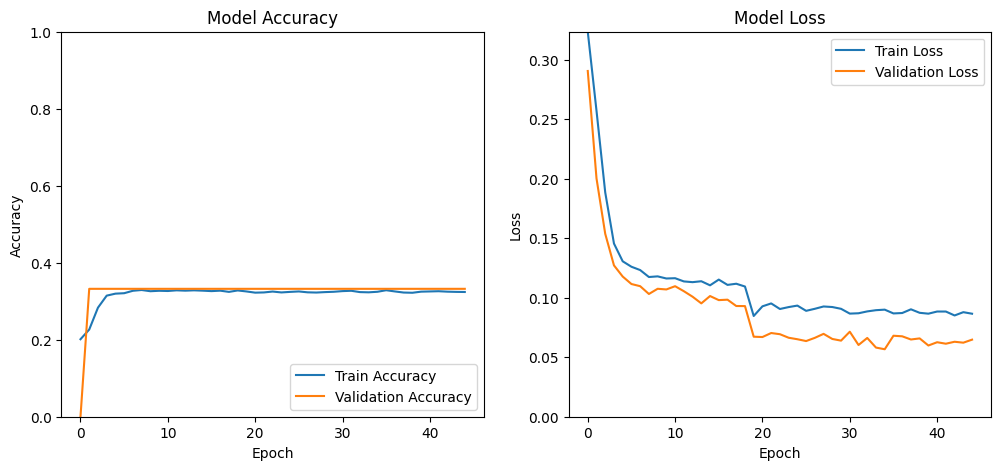

In [37]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(history.history['loss'])])
plt.legend(loc='upper right')
plt.title('Model Loss')


plt.savefig('/content/drive/MyDrive/training_plots_5000.png')

print("Plots saved as 'training_plots_5000.png'")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

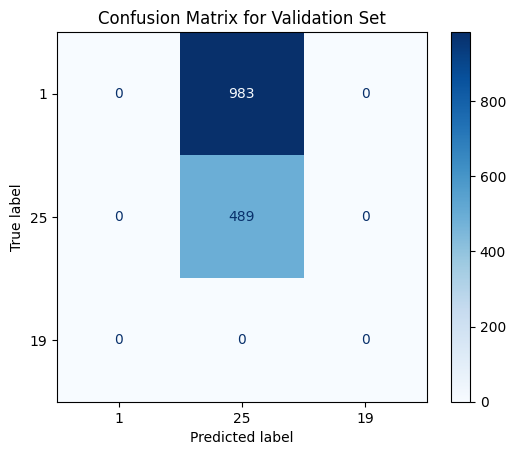

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Get predictions and true labels
y_pred = []
y_true = []

# Iterate over the validation dataset to get predictions and true labels
for images, labels in val_ds:
    # Predict classes for the current batch
    predictions = lstm_model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    y_pred.extend(predicted_classes)
    y_true.extend(true_classes)

# Step 2: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(CLASSES)))

# Step 3 (optional): Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Validation Set")
plt.show()

In [45]:
for images, labels in val_ds:
  print(images)
  print(labels)
  break


tf.Tensor(
[[[0.5737141  0.05958275 0.53064746 ... 0.06020821 0.6894892  0.        ]
  [0.8363559  0.0727459  0.46575314 ... 0.0967205  0.8560342  0.01454005]
  [0.8249722  0.11676199 0.5569422  ... 0.09254806 0.97114235 0.        ]
  ...
  [0.28843132 0.01066789 0.28292128 ... 0.02455526 0.96775025 0.01751983]
  [0.2923173  0.08301053 0.37004364 ... 0.01261733 0.91357344 0.0447146 ]
  [0.22809272 0.0152322  0.2670912  ... 0.00168494 0.8564361  0.06613174]]

 [[0.06313126 0.29888517 0.33287144 ... 0.05459344 0.06022876 0.4794964 ]
  [0.03874885 0.31734982 0.3775361  ... 0.01246669 0.14413232 0.4113311 ]
  [0.03471316 0.29508057 0.66234833 ... 0.02497032 0.23341617 0.6939431 ]
  ...
  [1.5418086  0.19547974 1.2037923  ... 0.03773854 0.         1.3613946 ]
  [1.4852616  0.11048668 1.3077167  ... 0.10200321 0.30738735 1.4155349 ]
  [0.9736914  0.21815915 1.2066016  ... 0.04870706 0.00756973 1.289406  ]]

 [[0.71893334 0.11408296 0.00197318 ... 0.46087325 0.         0.25486985]
  [0.762130